In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'analysis'))

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import h5py
import json
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy import signal
from functools import reduce
from imports import *
from analysis.loading import load_session_data
from session.sessions import selected_009266, selected_008229, selected_009265

import matplotlib.pyplot as plt

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
#selected_009266
selected_008229
#selected_009265

['008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-20_15-54-39',
 '008229_hippoSIT_2022-05-18_14-36-18']

## Read MoSeq source file

In [8]:
source

'/mnt/nevermind.data-share/ag-grothe/Andrey/analysis/MoSeq/results'

In [13]:
#source = '/home/sobolev/nevermind/Miguel/MoSeq/TrainedModels/MoSeqProject_ALLhippoSIT/2023_01_22-16_22_54'
#source = '/home/sobolev/nevermind/Andrey/analysis/DLC/MoSeq/10fps'
source = '/home/sobolev/nevermind/Andrey/analysis/MoSeq/results'
#source = '/mnt/nevermind.data-share/ag-grothe/Andrey/analysis/MoSeq/results'
session = selected_008229[0]

filt = [s for s in os.listdir(source) if s.startswith(session)]
if len(filt) > 0:
    moseq_file = os.path.join(source, filt[0])
    print("Found MoSeq file")
else:
    print("No MoSeq file for that session")

Found MoSeq file


In [14]:
ds = pd.read_csv(moseq_file)
ds.head()

syllables reindexed  syllables non-reindexed  centroid x  centroid y  \
0                    2                       82    617.0446    127.4131   
1                    2                       82    617.3593    127.4852   
2                    2                       82    615.6161    133.6536   
3                    2                       82    616.2345    134.0113   
4                    2                       82    616.5646    135.5285   

   heading  estimated left_eye x  estimated left_eye y  estimated right_eye x  \
0   1.3730              624.6819              140.0827               609.6564   
1   1.7297              611.6738              151.4319               597.2071   
2   2.1715              613.1118              145.8070               603.7877   
3   2.0459              615.8642              148.2531               605.0786   
4   1.9536              616.9005              149.8722               606.7854   

   estimated right_eye y  estimated left_ear x  ...  estimated right_hip y  \
0               133.6857              627.2717  ...               125.2797   
1               163.9044              625.5019  ...                87.8486   
2               143.7918              618.7785  ...               116.6650   
3               144.8670              621.0288  ...               118.0985   
4               147.3233              621.7898  ...               120.9462   

   latent_state 0  latent_state 1  latent_state 2  latent_state 3  \
0         -2.8605          2.7593         -1.5788         -0.1955   
1          4.6644         -2.1807         -5.2618          1.9727   
2         -1.6576         -0.0438          0.9293          0.3719   
3         -1.5587          0.1691          0.6754          0.3677   
4         -1.6000          0.2642          0.6043          0.5735   

   latent_state 4  latent_state 5  latent_state 6  latent_state 7  \
0         -0.9608         -0.3716         -1.1929         -1.8936   
1          1.4148          5.1785         -0.1719         -3.8124   
2          0.5609         -1.2030          0.2963         -0.2094   
3          0.0905         -1.4436         -0.0062         -1.6705   
4          0.0079         -2.0334         -0.0190         -1.6202   

   latent_state 8  
0         -0.7051  
1          3.9014  
2          0.8537  
3         -0.1696  
4          0.2985  

[5 rows x 40 columns]

## Create moseq processed file in the session

In [15]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source = '/mnt/nevermind.data-share/ag-grothe/Andrey/data'

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5_file     = os.path.join(sessionpath, session + '.h5')
moseq_file  = os.path.join(sessionpath, 'moseq.h5')

In [16]:
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])
    cfg = json.loads(f['processed'].attrs['parameters'])

In [17]:
# compare lengths of timeline (~100Hz) and MoSeq detected coords / syllables
ds1 = ds.copy()
tl.shape, ds1.shape

((239999, 7), (47998, 40))

In [18]:
# select only required columns
#columns_to_drop = ['Unnamed: 0', 'session_name', 'uuid', 'onset']
#ds1 = ds1.drop(columns=columns_to_drop)

In [19]:
def px_to_meters(cfg, x, y):  # convert pixels to meters
    cfg_pos = cfg['position']
    pixel_size = cfg_pos['floor_r_in_meters'] / float(cfg_pos['floor_radius'])
    x_m = float(cfg_pos['arena_x'] - x) * pixel_size * (-1 if cfg_pos['flip_x'] else 1)
    y_m = float(cfg_pos['arena_y'] - y) * pixel_size * (-1 if cfg_pos['flip_y'] else 1)
    return x_m, y_m

In [20]:
# convert pixels to meters in all variables
variables = [x[:-2] for x in ds1.columns if x.find(' x') > 0]
for variable in variables:
    var_x, var_y = variable + ' x', variable + ' y'
    converted = np.array([px_to_meters(cfg, x, y) for x, y in zip(ds[var_x], ds[var_y])])
    ds1[var_x] = converted[:, 0]
    ds1[var_y] = converted[:, 1]
    
print("Converted %d variables" % len(variables))

Converted 14 variables


In [21]:
# interpolate syllables assuming frames are evenly distributed
t_start, t_end = tl[0][0], tl[-1][0]

x_moseq = np.linspace(t_start, t_end, len(ds1))  # moseq timeline in seconds
moseq_matrix = np.zeros((len(tl), len(ds1.columns)))  # collect moseq data into numpy array

curr_idx = 0
for i, t in enumerate(tl[:, 0]):
    if curr_idx < len(x_moseq) - 1 and \
        np.abs(t - x_moseq[curr_idx]) > np.abs(t - x_moseq[curr_idx + 1]):
        curr_idx += 1
        
    moseq_matrix[i] = np.array(ds1.iloc[curr_idx])

In [22]:
# create a DataFrame from it
moseq_df = pd.DataFrame(moseq_matrix, columns=ds1.columns)

Text(0, 0.5, 'X Position')

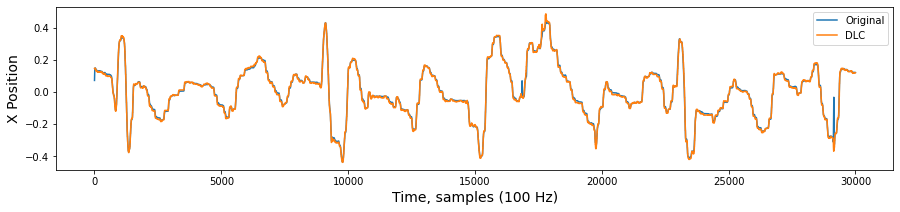

In [23]:
# test centroid position
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(tl[:, 1][:30000], label='Original')
ax.plot(moseq_matrix[:, 2][:30000], label='DLC')
ax.legend(loc='upper right')
ax.set_xlabel('Time, samples (100 Hz)', fontsize=14)
ax.set_ylabel('X Position', fontsize=14)

In [24]:
# save moseq data to the session folder
with h5py.File(moseq_file, 'w') as f:
    ds_h5 = f.create_dataset('moseq', data=moseq_matrix)
    ds_h5.attrs['headers'] = ', '.join(list(ds1.columns))